# Building Micrograd - Part 2

From this lecture: https://www.youtube.com/watch?v=VMj-3S1tku0

Micrograd is a neural network library that uses the neural network system to build mathematical functions, and can be used to find the derivatives of variables relative to wher ethe backpropagation was formed. You can find more out abotu micrograd here: https://github.com/karpathy/micrograd

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Value object

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children) 
        self._op = _op 
        self.label = label
        self.grad = 0.0 
        self._backward = lambda: None 

    def __repr__(self) -> str:
        return f"Value(data={self.data})" 
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') 
        def _backward():
            self.grad += 1.0 * out.grad # changed to += to allow for multiple calls
            other.grad += 1.0 * out.grad # changed to += to allow for multiple calls
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad # changed to += to allow for multiple calls
            other.grad += self.data * out.grad # changed to += to allow for multiple calls
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad # changed to += to allow for multiple calls
        out._backward = _backward
        return out
    
    # Our backwards pass
    def backward(self):
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [3]:
# Let's add in some visualisation
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [4]:
# Reset the data
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# Add together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# add bias
n = x1w1x2w2 + b; n.label = 'n'
# activation
o = n.tanh(); o.label = 'o'

o.backward()

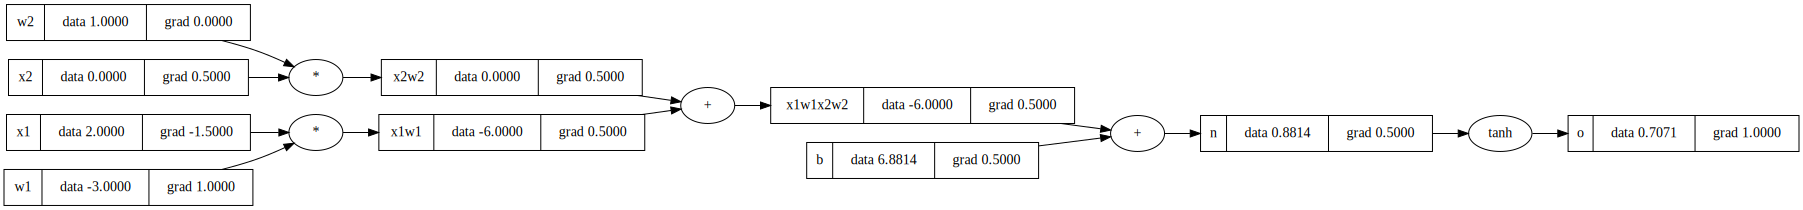

In [5]:
draw_dot(o)